<a href="https://colab.research.google.com/github/dimboz-3/pets_rm_bg/blob/main/text_bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
import torchvision

import numpy as np

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# нужно руками создать ссылку на папку
# https://drive.google.com/drive/folders/1qycdDzaDBtbE296Bsz9CaaneEoBVXq_-?usp=sharing
#

%cd drive/MyDrive/used_datasets

Mounted at /content/drive
/content/drive/Othercomputers/DIMBOZ/used_datasets


In [ ]:
import pandas as pd
import os
from PIL import Image
import random

##------------------------------------------->>>
class Dataset_RAM(Dataset):
    def __init__(self, Ds: Dataset,transform=None):
        self.transform = transform
        data=[]
        for x,y in Ds:
            data.append((x,y))
            
    def __len__(self):
        return len(data)       
    
    def __getitem__(self, idx):
        return data[idx]

##-------------------------------------------|||    
    
class csv_bin_img_Dataset(Dataset):
    def __init__(self, folder, transform=None,common_transform=None):
        self.transform = transform
        self.common_transform=common_transform
        print(self.common_transform)
        folder_name = os.path.basename(folder)
        self.file_name = os.path.join(folder, "dataset_info.csv")
        print("csv file is ",self.file_name)
        if not os.path.isfile(self.file_name):
            assert(False)
        
        self.samples_frame = pd.read_csv(self.file_name,delimiter=";")
        self.root_dir = folder
        
    def __len__(self):
        return len(self.samples_frame)
    
    def __getitem__(self, idx): 
        #print('getitem --- ',idx)
        img_name = self.samples_frame.at[idx,'img']
        msk_name = self.samples_frame.at[idx,'gt']
        img_file_name = os.path.join(self.root_dir,img_name)
        msk_file_name =  os.path.join(self.root_dir,msk_name)
        img = Image.open(img_file_name)
        msk  = Image.open(msk_file_name)
        #font_size = self.samples_frame.at[idx, 'size']
        
        img = np.array(img)[:,:,:3]
        
        msk=np.array(msk)
        if len(msk.shape)>2:
            msk = np.sum(np.array(msk),2)
        msk=(msk==0).astype(float)[None,...]



        #to torch.tensor shape
        #msk = msk.transpose((2,0,1))
        
        #print("init_img",type(image),image.size)
        if self.transform:
            img = self.transform(img)
            #print("after_transform",type(image),image.size())
            #print("max_is",image.max())
        msk = torch.from_numpy(msk)
        if self.common_transform:
            curr_seed = random.randint(0,10000)
            #print(curr_seed)
            torch.manual_seed(curr_seed)
            img = self.common_transform(img)
            torch.manual_seed(curr_seed)
            msk = self.common_transform(msk)
        return (img, msk, 0)
    

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import random

#прообразование, которое использовалось сетью ImageNet для предобработки данных
trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.1, hue=0.1),
  transforms.GaussianBlur(15, sigma= (2)), # подбирается экспериментально, в зависимости от уровня обученности сети
  #transforms.RandomInvert(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
#размер окна, которое будет вырезать из изображений. Ипользовалось и как средство для объединения 
# Изображений в batch- чи и для ограничения нагрузки на оперативную и видеопамять. При слишком большом изображении
# памяти видеокарты может не хватить.
w_size = 400
common_trans = transforms.Compose([
    transforms.RandomCrop(w_size, pad_if_needed=True)
])
# use the same transformations for train/val in this example


#Загрузка датасетов, найденных в интернете ( Конкурс распознавания изображений)
#https://habr.com/ru/company/smartengines/blog/344550/
ds_dib2016 = csv_bin_img_Dataset("DIBCO_2016",transform = trans,common_transform = common_trans)
ds_dib2013 =csv_bin_img_Dataset("DIBCO2013-dataset",transform = trans,common_transform = common_trans)
ds_dib2012 =csv_bin_img_Dataset("H-DIBCO2012-dataset",transform = trans,common_transform = common_trans)
ds_dib2011 =csv_bin_img_Dataset("DIBCO11-machine_printed",transform = trans,common_transform = common_trans)

#Нашел через поиск google по датасетам
ds_MC =csv_bin_img_Dataset("MCSset",transform = trans,common_transform = common_trans)
ds_Office =csv_bin_img_Dataset("NoisyOffice",transform = trans,common_transform = common_trans)
#собирал из картинок в интернете, и добавлял в ручном режиме фон из различных документов или шум
ds_stamp =csv_bin_img_Dataset("stamp",transform = trans,common_transform = common_trans)
ds_rus =csv_bin_img_Dataset("rus_article",transform = trans,common_transform = common_trans)

Compose(
    RandomCrop(size=(400, 400), padding=None)
)
csv file is  DIBCO_2016/dataset_info.csv
Compose(
    RandomCrop(size=(400, 400), padding=None)
)
csv file is  DIBCO2013-dataset/dataset_info.csv
Compose(
    RandomCrop(size=(400, 400), padding=None)
)
csv file is  H-DIBCO2012-dataset/dataset_info.csv
Compose(
    RandomCrop(size=(400, 400), padding=None)
)
csv file is  DIBCO11-machine_printed/dataset_info.csv
Compose(
    RandomCrop(size=(400, 400), padding=None)
)
csv file is  MCSset/dataset_info.csv
Compose(
    RandomCrop(size=(400, 400), padding=None)
)
csv file is  NoisyOffice/dataset_info.csv
Compose(
    RandomCrop(size=(400, 400), padding=None)
)
csv file is  stamp/dataset_info.csv
Compose(
    RandomCrop(size=(400, 400), padding=None)
)
csv file is  rus_article/dataset_info.csv


In [ ]:
!ls -g

total 32
drwx------ 2 root 4096 May 29 21:26 DIBCO11-machine_printed
drwx------ 2 root 4096 May 29 21:26 DIBCO2013-dataset
drwx------ 2 root 4096 May 29 21:26 DIBCO_2016
drwx------ 2 root 4096 May 29 21:26 H-DIBCO2012-dataset
drwx------ 2 root 4096 May 29 21:26 MCSset
drwx------ 2 root 4096 May 29 21:26 NoisyOffice
drwx------ 2 root 4096 May 29 21:26 rus_article
drwx------ 2 root 4096 May 29 21:26 stamp


## Prepare Dataset and DataLoader

In [ ]:



#ds_dib2016
#ds_dib2013
#ds_dib2012
#ds_dib2011
#ds_MC
#ds_Office
#ds_stamp
#ds_rus
#учил последовательно на всех датасетак
dataset = ds_Office

dataset_len = len(dataset)
print("dataset_len is:",dataset_len)
dataset_idx = list(range(dataset_len))
random.shuffle(dataset_idx)

train_part = 0.9
train_lenght = int(dataset_len*train_part)

train_idx, val_idx = dataset_idx[:train_lenght], dataset_idx[train_lenght:]

print("train_idx_len", len(train_idx))
print("val_idx_len", len(val_idx))
batch_size = 11

dataloaders = {
  'train': DataLoader(dataset, sampler = train_idx, batch_size=batch_size),
  'val':   DataLoader(dataset, sampler = val_idx, batch_size=batch_size)
}
print(len(dataloaders["train"]),len(dataloaders["val"]))

dataset_len is: 216
train_idx_len 194
val_idx_len 22
18 2


## Check the outputs from DataLoader

torch.Size([1, 3, 400, 400]) torch.Size([1, 1, 400, 400]) torch.float32
(400, 400, 1)
(400, 400, 3)
torch.Size([1, 3, 400, 400]) torch.Size([1, 1, 400, 400]) torch.float32
(400, 400, 1)
(400, 400, 3)
torch.Size([1, 3, 400, 400]) torch.Size([1, 1, 400, 400]) torch.float32
(400, 400, 1)
(400, 400, 3)
torch.Size([1, 3, 400, 400]) torch.Size([1, 1, 400, 400]) torch.float32
(400, 400, 1)
(400, 400, 3)
torch.Size([1, 3, 400, 400]) torch.Size([1, 1, 400, 400]) torch.float32
(400, 400, 1)
(400, 400, 3)


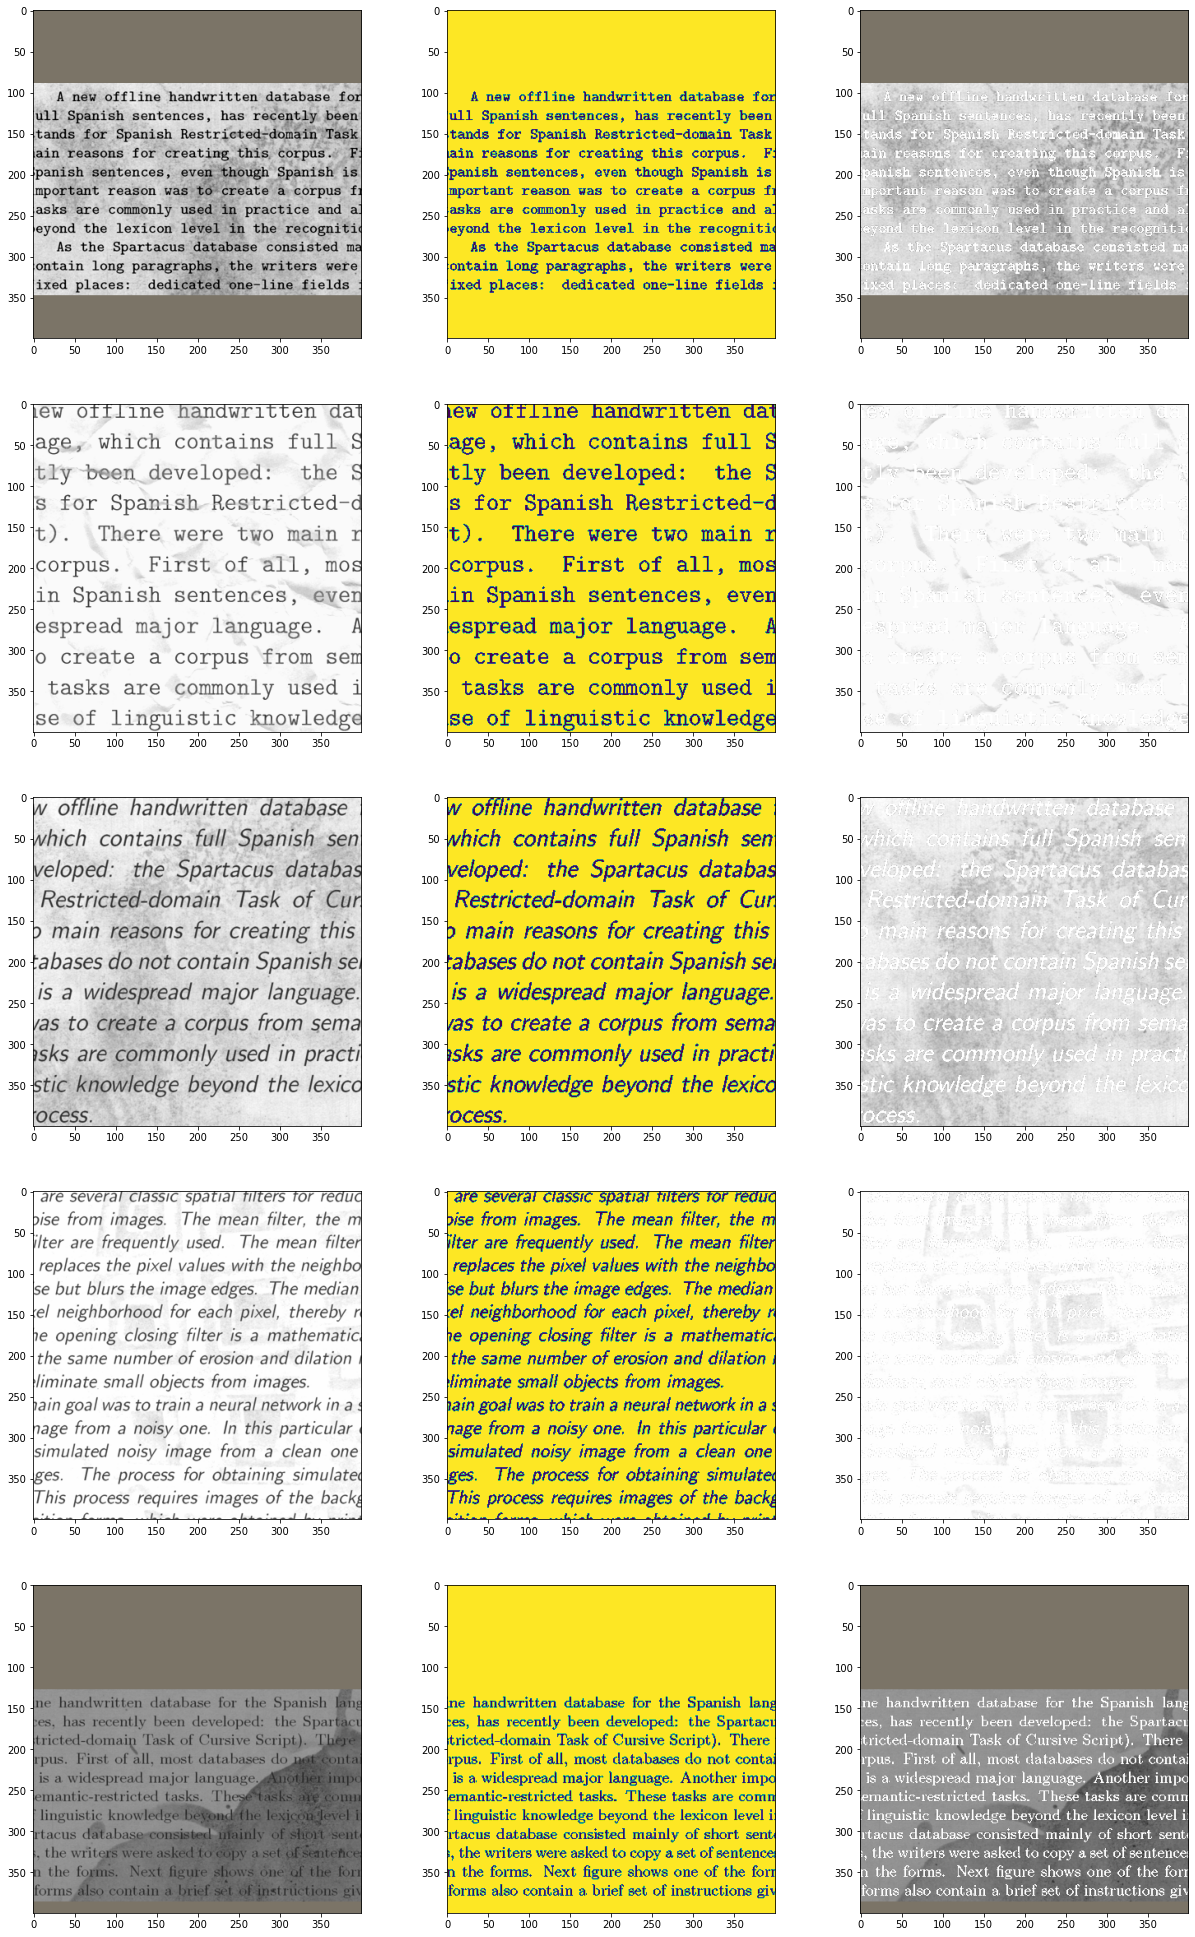

In [ ]:
import torchvision.utils
import torch
import matplotlib.pyplot as plt


def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])


#img_t -->image tensor
def reverse_transform(img_t,mask):
  img_t = img_t.numpy().transpose((1, 2, 0))
  mask = mask.numpy().transpose((1, 2, 0)).astype(np.uint8)
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img_t = std * img_t + mean
  img_t = np.clip(img_t, 0, 1)
  img = (img_t * 255).astype(np.uint8)

  mask_scale= mask==0
  return (img*mask_scale+255*(mask_scale==0)).astype(np.uint8), img, mask_scale

dataloader_iter = iter(dataloaders['train'])

N=max(min(len(dataloader_iter),5),2)
img_size = 7
f, plots = plt.subplots(N, 3,
                        figsize=(3 * img_size,N * img_size))
for i in range(N):
  inputs, mask, size = next(dataloader_iter)
  print(inputs.shape,mask.shape,inputs.dtype)
  img_mask, img, mask = reverse_transform(inputs[0], mask[0])
  print(mask.shape)
  print(img.shape)
  plots[i,0].imshow(img)
  plots[i,1].imshow(mask[:,:,0])
  plots[i,2].imshow(img_mask)


## Enabling GPU on Colab

Need to enable GPU from Notebook settings

- Navigate to Edit-Notebook settings menu
- Select GPU from the Hardware Accelerator dropdown list


In [ ]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

Exception: ignored

# Define a UNet module

In [ ]:
import torch.nn as nn
import torchvision.models
import torch.nn.functional as F


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)
  def _cat(self,x1,x2):
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
    x11 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])
    return torch.cat([x11, x2], dim=1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = self._cat(x,layer3)#torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = self._cat(x,layer2)#torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = self._cat(x,layer1)#torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = self._cat(x,layer0)#torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = self._cat(x,x_original)#torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

## Instantiate the UNet model

- Move the model to GPU if available
- Show model summaries

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(1)
model = model.to(device)

device cpu


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Define the main training loop

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import time
#"../drive/MyDrive/colab_output/rm_bg/resnet_unet_rm_bg_for_pets.pth"

import IPython


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        if epoch ==0:
            phase_arr = ['val','train', 'val']
        else:
            phase_arr = ['train', 'val']
        for phase in phase_arr:
            print("phase:--------------------------------------->",phase)
            if phase == 'train':
                model.train()  # Set model to training mode
                model.base_model.eval()
            else:
                model.eval()   # Set model to evaluate mode
            print("mode.base_model in training:",model.base_model.training)

            metrics = defaultdict(float)
            epoch_samples = 0
            !date

            #print("total examples:", len(dataloaders[phase]))
            out = display(IPython.display.Pretty('example_num:'), display_id=True)
            for i,(inputs, labels, size) in enumerate(dataloaders[phase]):
                #!date
                out.update(IPython.display.Pretty('example_num:'+str(i)))

                inputs = inputs.to(device)
                labels = labels.to(device)

                #print(inputs.shape,labels.shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if (phase != 'train'):
                      outputs=outputs.detach()
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            
            if phase == 'train':
              if scheduler is not None:
                  scheduler.step()
                  for param_group in optimizer.param_groups:
                      print("LR", param_group['lr'])
                
            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

## Training

In [ ]:
checkpoint_path = "/content/drive/Othercomputers/SERV-?/datasets/serv_ml__unet_text_bin.pth"


import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
num_class = 1
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False

print("batch_size", dataloaders["train"].batch_size)

#optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

optimizer_ft = optim.Adadelta(model.parameters())
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)


if os.path.exists(checkpoint_path):
  model.load_state_dict(torch.load(checkpoint_path,map_location=torch.device('cpu')))
  print("model loaded")
model = train_model(model, optimizer_ft, None, num_epochs=30)# exp_lr_scheduler

batch_size 11
model loaded
Epoch 0/29
----------
phase:---------------------------------------> val
mode.base_model in training: False
Wed Jun  1 15:44:44 UTC 2022


example_num:1

val: bce: 0.057545, dice: 0.106817, loss: 0.082181
saving best model to /content/drive/Othercomputers/SERV-?/datasets/serv_ml__unet_text_bin.pth
phase:---------------------------------------> train
mode.base_model in training: False
Wed Jun  1 15:45:31 UTC 2022


example_num:17

train: bce: 0.059059, dice: 0.110290, loss: 0.084675
phase:---------------------------------------> val
mode.base_model in training: False
Wed Jun  1 16:06:17 UTC 2022


example_num:1

val: bce: 0.061403, dice: 0.112375, loss: 0.086889
22m 21s
Epoch 1/29
----------
phase:---------------------------------------> train
mode.base_model in training: False
Wed Jun  1 16:07:04 UTC 2022


example_num:17

train: bce: 0.060164, dice: 0.111942, loss: 0.086053
phase:---------------------------------------> val
mode.base_model in training: False
Wed Jun  1 16:27:47 UTC 2022


example_num:1

val: bce: 0.067578, dice: 0.115774, loss: 0.091676
21m 30s
Epoch 2/29
----------
phase:---------------------------------------> train
mode.base_model in training: False
Wed Jun  1 16:28:34 UTC 2022


example_num:13

In [ ]:
torch.save(model, "unet_text_bin.model")

In [ ]:
dataloaders["train"].batch_size

## Predict new images using the trained model

In [ ]:
import math

model.eval()   # Set model to the evaluation mode

# Create a new simulation dataset for testing

import torchvision.utils
import torch

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])


#img_t -->image tensor
def reverse_img(img_t):
  img_t = img_t.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img_t = std * img_t + mean
  img_t = np.clip(img_t, 0, 1)
  img = (img_t * 255).astype(np.uint8)
  return img

def reverse_mask(mask_torch):
  mask = torch.sigmoid(mask_torch)
  mask = mask.numpy().transpose((1,2,0))
  return mask
def img_with_mask(img,mask):
  return (img*mask).astype(np.uint8)*255

dataloader_iter = iter(dataloaders['train'])

N=5# N>1
img_size = 7

f, plots = plt.subplots(N, 3,
                        figsize=(3 * img_size,N * img_size))

for i in range(N):
  inputs, mask, size = next(dataloader_iter)
  img = reverse_img(inputs[0])
  #print(mask.shape)
  mask = reverse_mask(mask[0])
  with torch.set_grad_enabled(False):
    mask_result = model(inputs.to(device)).data.cpu()
  #print(mask_result.shape)
 
  mask_result =  reverse_mask(mask_result[0])
  mask_result = (mask_result >0.2).astype(np.uint8)*255
  plots[i,0].imshow(img)
  plots[i,1].imshow(mask_result[:,:,0])
  plots[i,2].imshow(mask[:,:,0])


f.show()  



Смотрим работу на тестовых картинках из задания

In [ ]:
! ls -g ../testImages

In [ ]:
import os 
dirname = "../testImages"

from datetime import datetime
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%Y_%m_%d__%H_%M_%S")
dir_out = "../testImages/out_"+dt_string
!mkdir $dir_out
model.eval()

def inference_mask(img):
  inputs = trans(img)[None,...]
  with torch.set_grad_enabled(False):
      mask_result = model(inputs.to(device)).data.cpu()
  mask_result = reverse_mask(mask_result[0])[:,:,0]
  
  return (mask_result*255).astype(np.uint8),((mask_result>0.1)*255).astype(np.uint8)

def get_mask_by_cells(img,size=600):

  H,W,_ = img.shape

  H_count = H//size+1
  W_count = W//size+1

  H_step = H//H_count
  W_step = W//W_count
  #print("steps:",H_step,W_step)

  mask_gray=np.zeros_like(img[:,:,0])
  mask_bin=np.zeros_like(img[:,:,0])
  H_gr=np.append(np.arange(0,H,H_step)[:-1],H)
  W_gr=np.append(np.arange(0,W,W_step)[:-1],W)

  print(H_gr)
  print(W_gr)

  for h in range(len(H_gr)-1):
    for w in range(len(W_gr)-1):
      print(H_gr[h],H_gr[h+1],"__",W_gr[w],W_gr[w+1])
      img_gr = img[H_gr[h]:H_gr[h+1],W_gr[w]:W_gr[w+1]]
      #print(img_gr.shape)
      mask_gr_gray, mask_gr_bin = inference_mask(img_gr)

      mask_gray[H_gr[h]:H_gr[h+1],W_gr[w]:W_gr[w+1]] = mask_gr_gray
      mask_bin[H_gr[h]:H_gr[h+1],W_gr[w]:W_gr[w+1]] = mask_gr_bin
  return mask_gray,mask_bin
for file in os.listdir(dirname):
  full_path_file = os.path.join(dirname,file)
  if not os.path.isfile(full_path_file):
    continue
  img = Image.open(full_path_file)
  img = np.array(img)
  print(file,img.shape)
  #upsampling (by 3)
  H,W,_=img.shape
  img = img.repeat(3, axis=0).repeat(3, axis=1)
  mask_gray, mask_bin= get_mask_by_cells(img)
  #print(mask_result.dtype, mask_result.shape)

  filename, file_extension = os.path.splitext(file)
  print("----")
  Image.fromarray(mask_gray).save(os.path.join(dir_out,"mask_gray_"+filename+".png"))
  Image.fromarray(mask_bin).save(os.path.join(dir_out,"mask_bin_"+filename+".png"))


In [ ]:
np.append(np.arange(0,100,30),100)